In [31]:
# Imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [32]:
# Import VAR
from statsmodels.tsa.api import VAR

In [34]:
df.head()



,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [41]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [42]:
interpret_dftest(adfuller(df['realgdp']))

Test Statistic    1.750463
p-value           0.998246
dtype: float64

In [43]:
# Run ADF test on the original Real GDP data.
interpret_dftest(adfuller(df['realgdp'].diff(1).dropna()))

# so we wont train the model on real gdp we will train it on the FIRST DIFFERENCED !!!

Test Statistic   -6.305696e+00
p-value           3.327882e-08
dtype: float64

In [44]:
df['first_diff_gdp'] = df['realgdp'].diff(1)

In [45]:
interpret_dftest(adfuller(df['pop'].diff().diff().dropna()))

Test Statistic   -4.397672
p-value           0.000300
dtype: float64

In [46]:
interpret_dftest(adfuller(df['pop'].diff().diff().dropna()))

Test Statistic   -4.397672
p-value           0.000300
dtype: float64

In [47]:
df['second_diff_pop'] = df['pop'].diff().diff()

Assuming $\alpha=0.05$, take three minutes to achieve stationarity for `pop` and `unemp`. If needed, create the columns we want to model.

In [48]:
interpret_dftest(adfuller(df['unemp'].diff().diff().dropna()))

Test Statistic   -7.471142e+00
p-value           5.051153e-11
dtype: float64

In [49]:
df['first_diff_unemp'] = df['unemp'].diff()
df.head()

,realgdp,pop,unemp,first_diff_gdp,second_diff_pop,first_diff_unemp
1959-03-31,2710.349,177.146,5.8,NaN,NaN,NaN
1959-06-30,2778.801,177.830,5.1,68.452,NaN,-0.7
1959-09-30,2775.488,178.657,5.3,-3.313,0.143,0.2
1959-12-31,2785.204,179.386,5.6,9.716,-0.098,0.3
1960-03-31,2847.699,180.007,5.2,62.495,-0.108,-0.4


#### 2. Train/test split.

In [50]:
# Subset our data.
df = df[['first_diff_gdp', 'second_diff_pop', 'first_diff_unemp']].copy()

# Let's get rid of rows containing missing values.
df.dropna(inplace = True)

In [51]:
# What am I missing?

train, test = train_test_split(df,
                               test_size = 0.25, shuffle = False)

#### 3. Determine correct lag order $p$.

We can check out autocorrelation plots and partial autocorrelation plots to attempt to figure out how many previous values of **each variable** we want in our model.

Suppose I select $p=2$.

$$
\begin{eqnarray*}
Y^{(d)}_{1,t} &=& \beta_0 + \beta_1Y^{(d)}_{1,t-1} + \beta_2Y^{(d)}_{1,t-2} + \beta_3Y^{(d)}_{2,t-1} + \beta_4Y^{(d)}_{2,t-2} + \beta_5Y^{(d)}_{3,t-1} + \beta_6Y^{(d)}_{3,t-2} \\
\\
Y^{(d)}_{2,t} &=& \gamma_0 + \gamma_1Y^{(d)}_{1,t-1} + \gamma_2Y^{(d)}_{1,t-2} + \gamma_3Y^{(d)}_{2,t-1} + \gamma_4Y^{(d)}_{2,t-2} + \gamma_5Y^{(d)}_{3,t-1} + \gamma_6Y^{(d)}_{3,t-2} \\
\\
Y^{(d)}_{3,t} &=& \delta_0 + \delta_1Y^{(d)}_{1,t-1} + \delta_2Y^{(d)}_{1,t-2} + \delta_3Y^{(d)}_{2,t-1} + \delta_4Y^{(d)}_{2,t-2} + \delta_5Y^{(d)}_{3,t-1} + \delta_6Y^{(d)}_{3,t-2}
\\
\end{eqnarray*}
$$

However, we can automate the selection of $p$ using a metric called the Akaike information criterion, or the AIC.

##### AIC

The AIC is a metric that is commonly used for time series models or in more "statistics-oriented" fields.
- Recall that models are just simplifications of reality. AIC attempts to measure how much information we lose when we simplify reality with a model.
- The lower the AIC, the better!
- More details can be found at the [Wikipedia page](https://en.wikipedia.org/wiki/Akaike_information_criterion).

We can actually find a good value of $p$ when we fit our model!

#### 4. Fit model.

In [52]:
# Instantiate a VAR model. Remember that we pass
# our data in during instantiation in statsmodels!
model = VAR(train)

/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


In [53]:
# Fit our model and use AIC to select the value of p.

ts_model = model.fit(maxlags=15, # what is the largest possible value of p?
                     ic = 'aic')   # what "information criterion" (ic) will we use to decide what's "best?"

In [54]:
# What is the order of our autoregressive model? 
ts_model.k_ar

4

In [55]:
# Check out the summary of our model!
ts_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 15, Feb, 2024
Time:                     13:19:05
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                  -0.996910
Nobs:                     146.000    HQIC:                  -1.47007
Log likelihood:          -451.540    FPE:                   0.166546
AIC:                     -1.79390    Det(Omega_mle):        0.128944
--------------------------------------------------------------------
Results for equation first_diff_gdp
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      23.250741        10.473768            2.220           0.026
L1.first_diff_gdp           0.103736         0.100731            1.030           0.303
L1.second_diff_pop       -1

#### 5. Generate forecasts.

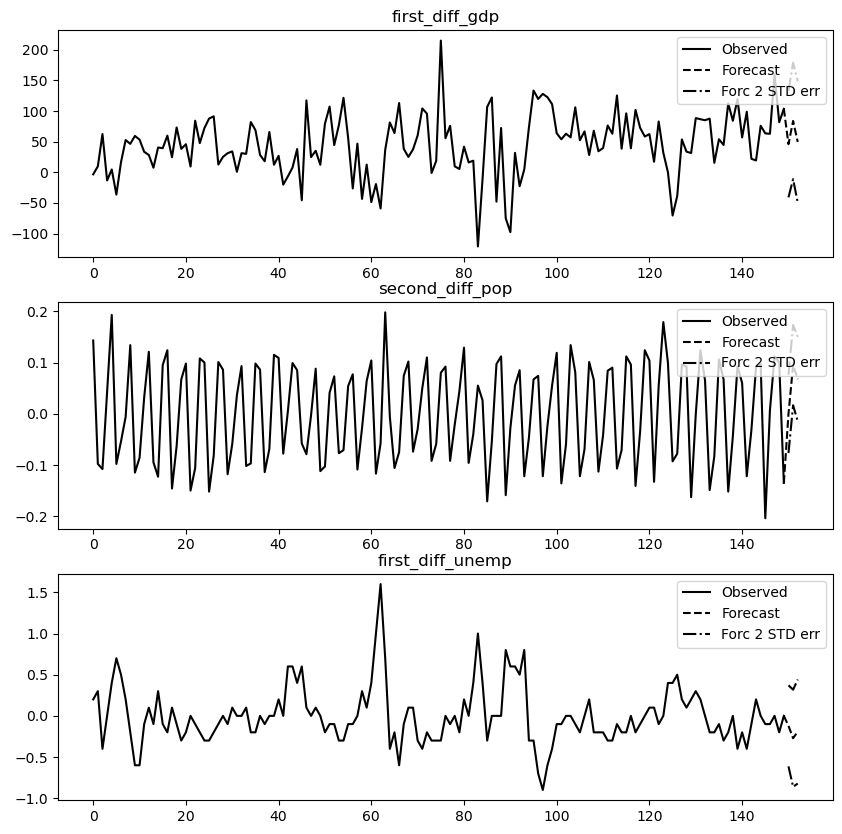

In [65]:
# Plot the forecast looking 3 steps ahead.
ts_model.plot_forecast(3);

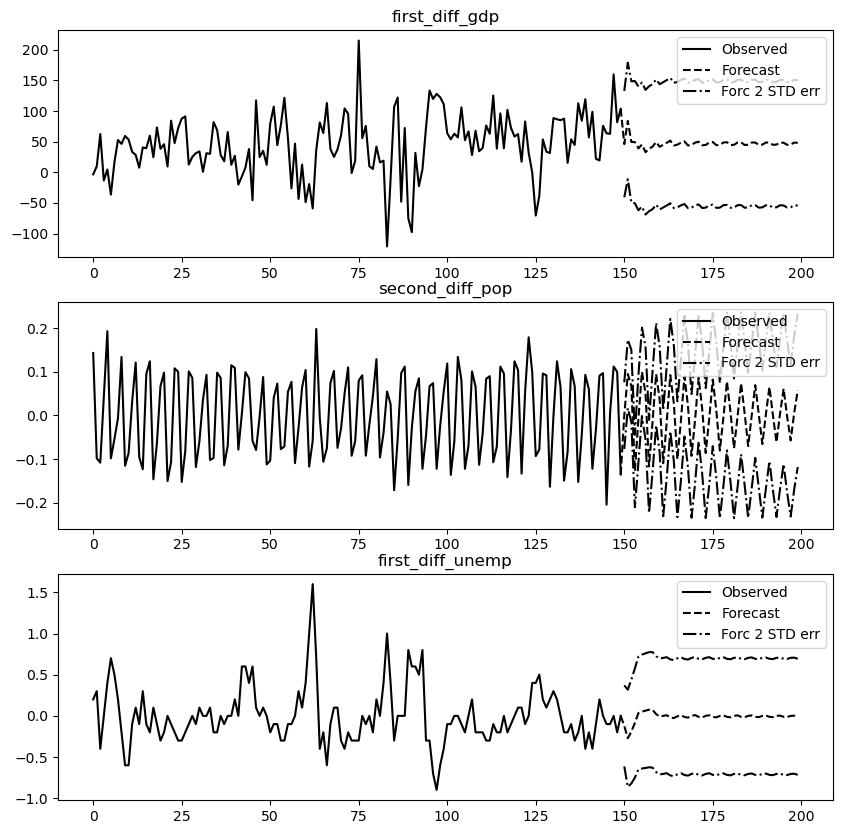

In [70]:
# Plot the forecast looking 50 steps ahead.
ts_model.plot_forecast(50);

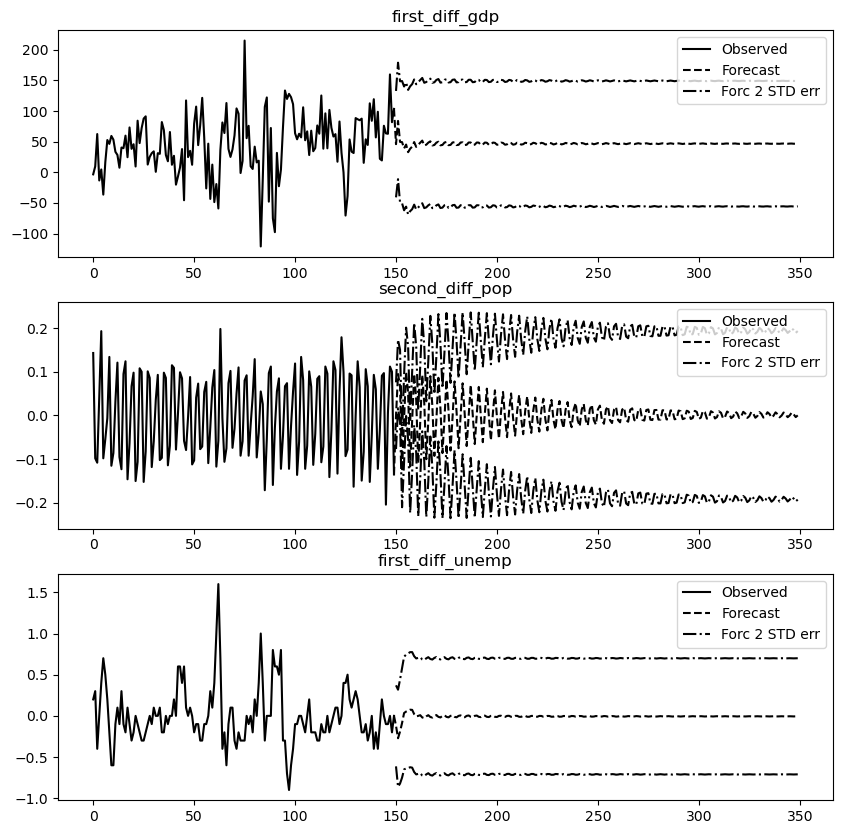

In [71]:
# Plot the forecast looking 200 steps ahead.
ts_model.plot_forecast(200);

In [68]:
# Generate a forecast one step ahead.
ts_model.forecast(train.values, 1)

array([[ 4.60133719e+01, -4.35975472e-04, -1.21245774e-01]])

In [72]:

# Generate a forecast five steps ahead.
ts_model.forecast(train.values, 5)

array([[ 4.60133719e+01, -4.35975472e-04, -1.21245774e-01],
       [ 8.39109946e+01,  9.49079885e-02, -2.71839880e-01],
       [ 4.96001022e+01,  6.76670319e-02, -1.90197121e-01],
       [ 4.92837943e+01, -1.27157164e-01, -8.64169194e-02],
       [ 3.90626298e+01, -7.29535302e-03,  3.46047233e-02]])

In [73]:

# Generate a forecast that matches our testing set.
ts_model.forecast(train.values, len(test))

array([[ 4.60133719e+01, -4.35975472e-04, -1.21245774e-01],
       [ 8.39109946e+01,  9.49079885e-02, -2.71839880e-01],
       [ 4.96001022e+01,  6.76670319e-02, -1.90197121e-01],
       [ 4.92837943e+01, -1.27157164e-01, -8.64169194e-02],
       [ 3.90626298e+01, -7.29535302e-03,  3.46047233e-02],
       [ 4.53110064e+01,  9.99029602e-02,  5.21223486e-02],
       [ 3.28672292e+01,  5.15480699e-02,  6.32787030e-02],
       [ 3.84698459e+01, -1.16634756e-01,  7.49054219e-02],
       [ 4.19244233e+01, -1.34473806e-02,  7.28128870e-02],
       [ 4.94275630e+01,  9.48906389e-02,  2.08012675e-02],
       [ 4.15626509e+01,  3.62083154e-02, -6.71500060e-03],
       [ 4.49504704e+01, -1.09126582e-01, -8.88058034e-05],
       [ 4.82000442e+01, -1.44566394e-02,  8.25916689e-03],
       [ 5.17925411e+01,  9.24596738e-02, -1.92757334e-02],
       [ 4.38708771e+01,  2.79263106e-02, -2.68906544e-02],
       [ 4.51195394e+01, -9.99923189e-02, -5.62392018e-03],
       [ 4.84578553e+01, -1.21217648e-02

In [75]:
# See the values of our test set.
forecast = ts_model.forecast(train.values, len(test))

#### 6. Evaluate model (and forecasts, if possible).

In [76]:
for i in range(test.shape[1]):
    print(f"The test MSE on the {test.columns[i]} data is: \
    {mean_squared_error(test.values[:,i], forecast[:, i])}")

The test MSE on the first_diff_gdp data is:     6943.75996339238
The test MSE on the second_diff_pop data is:     0.003333766344930133
The test MSE on the first_diff_unemp data is:     0.11594109961653103
